In [161]:
from sympy import *
from IPython.display import display, Math
import numpy as np
init_printing(use_unicode=True)
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from tqdm import tqdm

In [162]:
from sympy import solve

x, y, sigma, mu, delta, alpha, beta, ro, eta, b, lambd = symbols(
    'x y σ μ δ α β ρ η b λ')

sigma_c = 0.1181
ro_c = 1.131
eta_c = 20.19
alpha_c = 1.636
beta_c = 0.002
delta_c = 0.3743
mu_c = 0.005
b_c = 0

dxdt = sigma + ro*x*y/(eta + y) - mu*x*y - delta*x
dydt = alpha*y*(1-beta*y)-x*y-(b*y)/(1+y)

concrete_params = {ro: ro_c, sigma: sigma_c, eta: eta_c, b: b_c,
                   alpha: alpha_c, beta: beta_c, mu: mu_c, delta: delta_c}
muless_params = dict(concrete_params)
del muless_params[mu]

bless_params = dict(concrete_params)
del bless_params[b]


In [163]:
display(Math('\dfrac{dx}{dt} = ' + latex(dxdt)))
display(Math('\dfrac{dy}{dt} = ' + latex(dydt)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Точки равновесия

### 1

In [164]:
display(Math('x = ' + latex(sigma/delta)))
display(Math('y = 0' )) # Решение не зависит от μ

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [165]:
# Остаьные равновесия аналитически не найти. Полином 5 степени.

In [166]:
def get_solutions(params):
    return solve([dxdt.subs(params), dydt.subs(params)], x,y)

In [167]:
def display_solutions(sols):
    for s in sols:
        display(s)

In [168]:
def display_sol_list(sol_list):
    for cur_mu, sols in sol_list:
        print(f"mu = {cur_mu}")
        display_solutions(sols)
        display("*"*20)

In [169]:
from typing import Tuple

def sol_is_almost_real(sol):
    x, y = sol
    return abs(im(x)) < 1e-10 and abs(im(y)) < 1e-10 

def cast_to_real(sol):
    x, y = sol
    return re(x), re(y)

In [170]:
# for s in get_solutions():
#     display(s)

#### Бифуркационная диаграмма

In [171]:
# mus = np.linspace(0.002, 0.022, 50)

mus = np.concatenate([
    np.linspace(0.0020, 0.0026, 50, endpoint=False),
    np.linspace(0.0026, 0.00265, 50, endpoint=False),
    np.linspace(0.00265, 0.0040, 50, endpoint=False),
    np.linspace(0.0040, 0.0130, 50, endpoint=False),
    np.linspace(0.0131, 0.0133, 50, endpoint=False),
    np.linspace(0.0130, 0.0135, 50, endpoint=False),
    np.linspace(0.0135, 0.0220, 50, endpoint=False)
])

In [172]:
xs=[]
ys = []
mul = []
solutions_by_mu={}
for cur_mu in tqdm(mus):
    solutions = get_solutions(muless_params | {mu:cur_mu})
    solutions = [cast_to_real(s) for s in solutions if sol_is_almost_real(s)]
    solutions_by_mu[cur_mu]= solutions   

100%|█████████████████████████████████████████| 350/350 [11:45<00:00,  2.02s/it]


In [173]:
# y_im_parts = []
# x_im_parts = []
# mus_for_im=[]
# for cur_mu, sols in list(solutions_by_mu.items()):
#     for cur_x,cur_y in sols:
#         x_im_parts.append(float(cur_x))
#         y_im_parts.append(float(cur_y))
#         mus_for_im.append(cur_mu)
            
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=mus_for_im, y=x_im_parts, mode='markers', name = "x_im_parts"))
# fig.add_trace(go.Scatter(x=mus_for_im, y=y_im_parts, mode='markers', name = "y_im_parts"))
# fig.update_layout(title="Imaginary parts of X and Y")
# fig.update_layout(xaxis={"title": "mu"})


На отрезке [0.005, 0.015] мнимая часть близка к нулю

In [174]:
mu_min = 0.002
mu_max = 0.017
filtered_solutions_by_mu = {mu:solutions_by_mu[mu] for mu in solutions_by_mu if mu_min<mu<mu_max}
# filtered_solutions_by_mu

In [175]:
dfdx = diff(dxdt, x)
dfdy = diff(dxdt, y)
dgdx = diff(dydt, x)
dgdy = diff(dydt, y)

In [176]:
display(Math('\dfrac{df}{dx} = ' + latex(dfdx)))
display(Math('\dfrac{df}{dy} = ' + latex(dfdy)))
display(Math('\dfrac{dg}{dx} = ' + latex(dgdx)))
display(Math('\dfrac{dg}{dy} = ' + latex(dfdy)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [177]:
def get_eigen_values(x_eq, y_eq, params):
    a11 = dfdx.evalf(subs=params | {x:x_eq, y:y_eq})
    a12 = dfdy.evalf(subs=params | {x:x_eq, y:y_eq})
    a21 = dgdx.evalf(subs=params | {x:x_eq, y:y_eq})
    a22 = dgdy.evalf(subs=params | {x:x_eq, y:y_eq})
    jacob_matrix = Matrix([[a11, a12], [a21, a22]])
    j = jacob_matrix - np.eye(2) * lambd
    lam1, lam2 = solve(j.det(), lambd)
    return lam1, lam2

In [178]:
# display_sol_list(list(filtered_solutions_by_mu.items())[:2])

In [179]:
def get_line_mode(stable):
    return {} if stable else {"dash":"dot"}

In [191]:
xs=[]
ys=[]
mus_bif = []
df = pd.DataFrame(columns=['mu', 'x', 'y', 'stable'])
for cur_mu, sols in tqdm(list(filtered_solutions_by_mu.items())):
    for cur_x, cur_y in sols:
        lam1, lam2 = get_eigen_values(float(cur_x), float(cur_y), muless_params | {mu:cur_mu})
        stable = re(lam1) <0 and re(lam2)<0
        df.loc[len(df)] = [cur_mu, float(cur_x), float(cur_y), stable ]
            

df.stable = df.stable.astype(bool)
df = df[df.y!=0]


# fig.add_trace(go.Scatter(x=stables.mu, y=stables.y, mode='markers', name = "y"))



100%|█████████████████████████████████████████| 313/313 [01:51<00:00,  2.81it/s]


In [192]:
df.y = df.y.astype('float')
df.stable = df.stable.astype(bool)

df.sort_values('y', inplace=True)
stables = df[df.stable]
dormants = df[df.stable & (df.y < 200)]
actives = df[df.stable & (df.y > 200)]
unstables = df[~df.stable]

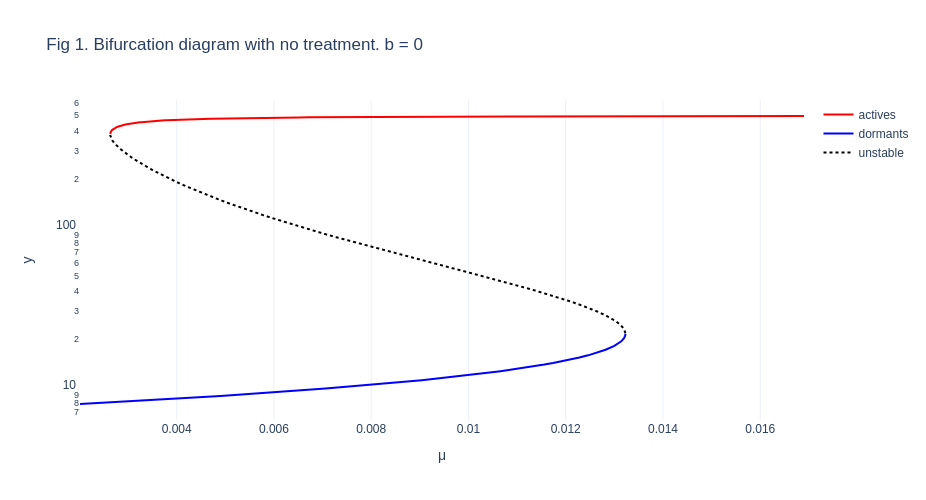

In [193]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=actives.mu, y=actives.y, mode='lines', name = "actives",
                        line={"color":"red"}|get_line_mode(stable=True)))

fig.add_trace(go.Scatter(x=dormants.mu, y=dormants.y, mode='lines', name = "dormants",
                        line={"color":"blue"}|get_line_mode(stable=True)))

fig.add_trace(go.Scatter(x=unstables.mu, y=unstables.y, mode='lines', name = "unstable",
                        line={"color":"black"}|get_line_mode(stable=False)))
# fig.add_trace(go.Scatter(x=df.mu, y=df.y, mode='markers', name = "y"))
fig.update_layout(title="Fig 1. Bifurcation diagram with no treatment. b = 0")
fig.update_layout(xaxis={"title": "μ"}, yaxis={"title": "y"}, template="plotly_white",autosize=False,
    width=600,
    height=500)
fig.update_yaxes(type="log")
# fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

## 𝜇 = 0.014. Monostable active. b is variable

In [194]:
mu_c = 0.014
bless_params[mu] = mu_c

In [195]:
def get_n_solutions_by_b(params, y_starts):
    res = set()
    for y_start in y_starts:
        try:
            res.add(ImmutableMatrix(nsolve([dxdt.subs(params), dydt.subs(params)], (x,y), (0,y_start)) ))
        except ValueError:#Could not find root within given tolerance. (1.56236416469305495856 > 2.16840434497100886801e-19)
# Try another starting point or tweak arguments.
            pass        
    return res

In [196]:
solutions_by_b={}
bs_full_range = np.concatenate([
    np.linspace(0.0, 200, 500, endpoint=False),
    np.linspace(194, 195, 50, endpoint=False),
    np.linspace(10, 25, 100, endpoint=False),
])
bs_smalls = np.concatenate([
    np.linspace(0.0, 10, 100, endpoint=False),
    np.linspace(8.2, 8.4, 100, endpoint=False)
])
for bs_set, y_starts in zip([bs_full_range, bs_smalls],
                           [np.linspace(0, 600, 6), np.linspace(0, 30, 6) ]):
    for curb in tqdm(bs_set):
        solutions = get_n_solutions_by_b(bless_params | {b:curb}, y_starts)
        solutions = [cast_to_real(s) for s in solutions if sol_is_almost_real(s)]
        solutions_by_b[curb]= solutions   

100%|█████████████████████████████████████████| 200/200 [00:34<00:00,  5.80it/s]


In [197]:
df = pd.DataFrame({'b': pd.Series(dtype='float'),
                   'x': pd.Series(dtype='float'),
                   'y': pd.Series(dtype='float'),
                   'stable': pd.Series(dtype='bool')})
for curb, sols in tqdm(solutions_by_b.items()):
    for sol in sols:
        cur_x, cur_y = sol
        lam1, lam2 = get_eigen_values(float(cur_x), float(cur_y), bless_params | {b:curb})
        stable = re(lam1) <0 and re(lam2)<0
        df.loc[len(df)] = [curb, float(cur_x), float(cur_y), stable]
        
df.stable = df.stable.astype(bool)
orig = df.copy()
    

100%|█████████████████████████████████████████| 815/815 [04:48<00:00,  2.82it/s]


In [198]:
# df = df[(df.y>=0) & (df.y.abs()>1e-10)]
df = df[(df.y>=0)]
df.sort_values('y', inplace=True)

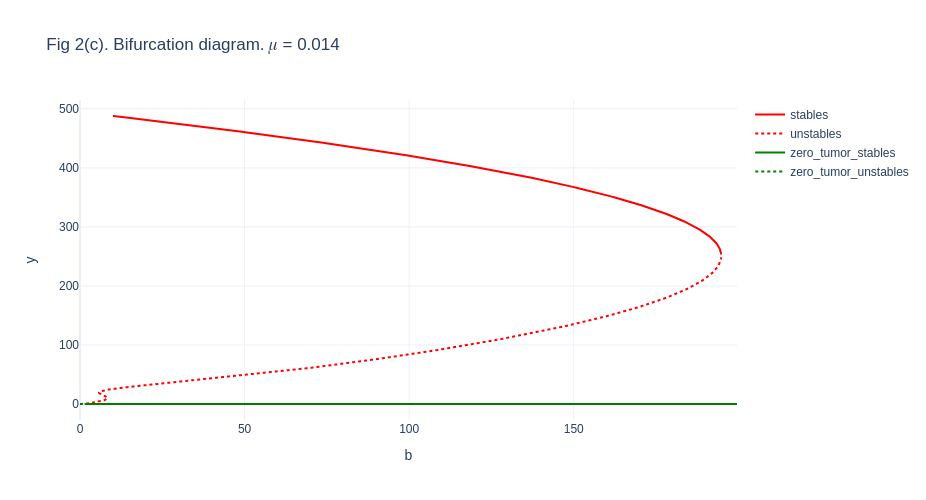

In [199]:
fig = go.Figure()
stables = df[df.stable & (df.y!=0)]
unstables = df[~df.stable & (df.y!=0)]
zero_tumor_stables = df[df.stable & (df.y==0)]
zero_tumor_unstables = df[~df.stable & (df.y==0)]

fig.add_trace(go.Scatter(x=stables.b, y=stables.y, mode='lines', name = "stables",
              line={"color":"red"}|get_line_mode(stable=True)))
fig.add_trace(go.Scatter(x=unstables.b, y=unstables.y, mode='lines', name = "unstables",
             line={"color":"red"}|get_line_mode(stable=False)))
fig.add_trace(go.Scatter(x=zero_tumor_stables.b, y=zero_tumor_stables.y, mode='lines', name = "zero_tumor_stables",
             line={"color":"green"}|get_line_mode(stable=True)))
fig.add_trace(go.Scatter(x=zero_tumor_unstables.b, y=zero_tumor_unstables.y, mode='lines', name = "zero_tumor_unstables",
             line={"color":"green"}|get_line_mode(stable=False)))

fig.update_layout(title="Fig 2(c). Bifurcation diagram. 𝜇 = 0.014")
fig.update_layout(xaxis={"title": "b"}, yaxis={"title": "y"}, template="plotly_white",autosize=False,
    width=700,
    height=500)

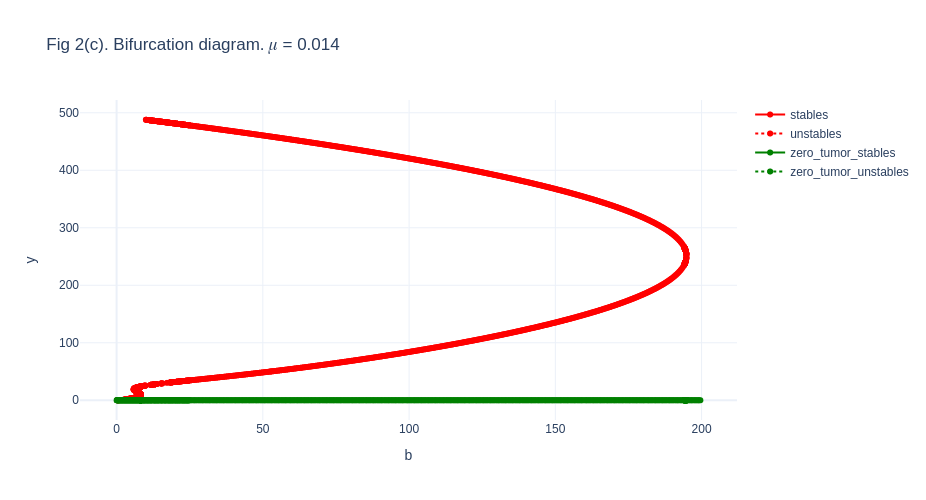

In [200]:
fig = go.Figure()
stables = df[df.stable & (df.y!=0)]
unstables = df[~df.stable & (df.y!=0)]
zero_tumor_stables = df[df.stable & (df.y==0)]
zero_tumor_unstables = df[~df.stable & (df.y==0)]

fig.add_trace(go.Scatter(x=stables.b, y=stables.y, mode='lines+markers', name = "stables",
              line={"color":"red"}|get_line_mode(stable=True)))
fig.add_trace(go.Scatter(x=unstables.b, y=unstables.y, mode='lines+markers', name = "unstables",
             line={"color":"red"}|get_line_mode(stable=False)))
fig.add_trace(go.Scatter(x=zero_tumor_stables.b, y=zero_tumor_stables.y, mode='lines+markers', name = "zero_tumor_stables",
             line={"color":"green"}|get_line_mode(stable=True)))
fig.add_trace(go.Scatter(x=zero_tumor_unstables.b, y=zero_tumor_unstables.y, mode='lines+markers', name = "zero_tumor_unstables",
             line={"color":"green"}|get_line_mode(stable=False)))

fig.update_layout(title="Fig 2(c). Bifurcation diagram. 𝜇 = 0.014")
fig.update_layout(xaxis={"title": "b"}, yaxis={"title": "y"}, template="plotly_white",autosize=False,
    width=700,
    height=500)

In [201]:
# Note: b в районе 10 - 20 - решения не находятся

In [202]:
dfsmall = df[df.b.isin(bs_smalls)]

In [203]:
b1 = 5.8
b2 = 8.3

In [204]:
pink = dfsmall[(dfsmall.b<b2) & (dfsmall.y<10) & ~dfsmall.stable & (dfsmall.y>1e-10)]
blue = dfsmall[(dfsmall.b>b1) & (dfsmall.b<b2) & (10<dfsmall.y) & (dfsmall.y<19) & ~dfsmall.stable]
red = dfsmall[(dfsmall.b>b1) & (dfsmall.y>19) & ~dfsmall.stable]

zero_tumor_stables = dfsmall[dfsmall.stable & (df.y==0)]
zero_tumor_unstables = dfsmall[~dfsmall.stable & (df.y==0)]


/tmp/ipykernel_7471/1742472432.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_7471/1742472432.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



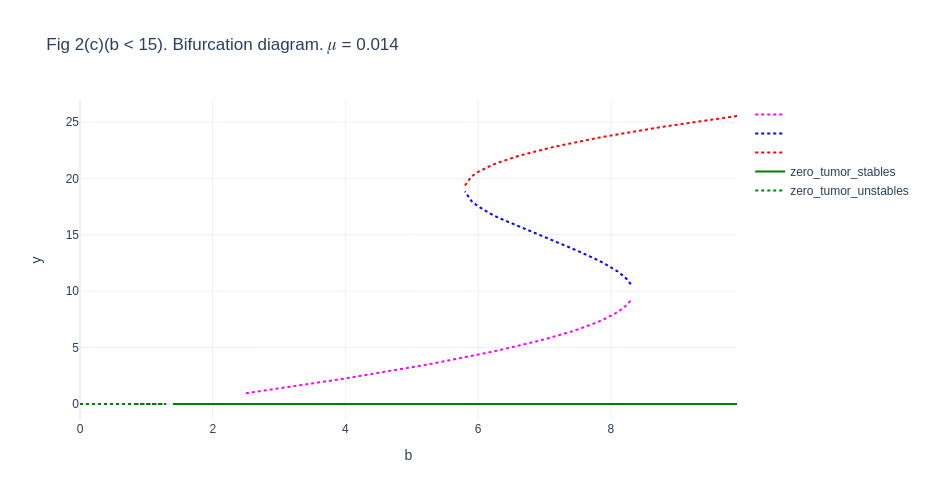

In [205]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=pink.b, y=pink.y, mode='lines', name = "",
              line={"color":"magenta"}|get_line_mode(stable=False)))

fig.add_trace(go.Scatter(x=blue.b, y=blue.y, mode='lines', name = "",                         
              line={"color":"blue"}|get_line_mode(stable=False)))

fig.add_trace(go.Scatter(x=red.b, y=red.y, mode='lines', name = "",
              line={"color":"red"}|get_line_mode(stable=False)))

fig.add_trace(go.Scatter(x=zero_tumor_stables.b, y=zero_tumor_stables.y, mode='lines', name = "zero_tumor_stables",
             line={"color":"green"}|get_line_mode(stable=True)))
fig.add_trace(go.Scatter(x=zero_tumor_unstables.b, y=zero_tumor_unstables.y, mode='lines', name = "zero_tumor_unstables",
             line={"color":"green"}|get_line_mode(stable=False)))

fig.update_layout(title="Fig 2(c)(b < 15). Bifurcation diagram. 𝜇 = 0.014")
fig.update_layout(xaxis={"title": "b"}, yaxis={"title": "y"}, template="plotly_white",autosize=False,
    width=700,
    height=500)